## <font color='Blue'>Introduction</font>
###  In the practical, we run the example model for evaluation of permebaility field.

## <font color='blue'>The objectives:</font>
1. Introduce custom <font color='red'>'Model'</font> class based on 
 * Class [DartsModel](./darts/models/darts_model.py) with base model capabilities
 * Class [StructReservoir](./darts/models/reservoirs/struct_reservoir.py) with structured reservoir
 * Class [Deadoil](./darts/models/physics/dead_oil_python.py) for basic dead oil physics
 * Class [Deadoil-properties](./darts/models/physics/do_properties_python.py) for dead oil properties, such as density, viscosity and relative permeability
2. Use run_python procedure to control run from the python script
3. Introduce wells and time-dependent well controls
4. Redefine physical properties and run simulation with custom-defined property.

## <font color='Blue'>Let's start!</font>


In [1]:
from darts.models.reservoirs.struct_reservoir import StructReservoir
from darts.models.physics.dead_oil_python import DeadOil
from darts.models.darts_model import DartsModel
from darts.engines import value_vector
from darts.tools.keyword_file_tools import load_single_keyword

import numpy as np
import matplotlib.pyplot as plt

#### Brief Introduction of model inheritance
* Here create the <font color='red'>'Model' </font>  class, which inherits from <font color='red'>DartsModel</font> (the base class).
* It keeps all the functionalities of <font color='red'>DartsModel</font> and can also be extended to add more functionalities.
* If a function is redefined in subclass, the function in base class with identical name will be overridden.

<img style="float: left;" src="slides/Slide12.JPG" width="80%">

In [2]:
# step 1 - load the variable collection
from scipy.io import loadmat
data = loadmat('2P_model.mat')
realiz = np.array(data['realz'])

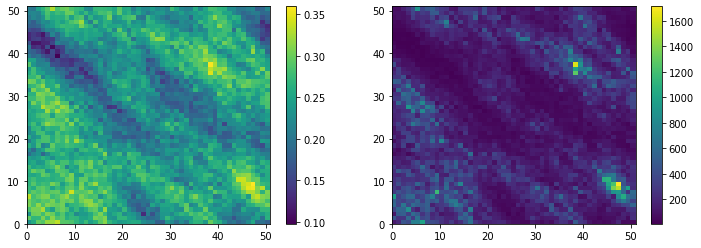

In [3]:
# step 1 - generate porosity and permeability fields based on realization
phi = 0.24 - np.mean(realiz) * 0.04 / np.std(realiz) + realiz * 0.04 / np.std(realiz)
k = 10 ** (9*phi)

nd = 51
nx = nd
ny = nd
# plot solution
plt.figure(num=2, figsize=(12,4))
plt.subplot(121)
plt.pcolor(phi.reshape(nx, ny))
plt.colorbar()

plt.subplot(122)
plt.pcolor(k.reshape(nx, ny))
plt.colorbar()
plt.show()

In [4]:
# step 6 - adjust BHP of four producers so that breakthrough happens simultaneously.

In [5]:
class Model(DartsModel):
    def __init__(self, perm=None, nd = 60, db = 8, t_run = 1000):
        # call base class constructor
        super().__init__()

        # measure time spend on reading/initialization
        self.timer.node["initialization"].start()

        # create reservoir
        self.nx = nd
        self.ny = nd
        self.nz = 1
        
        self.dx = db
        self.dy = db
        self.dz = 4

        if (perm is None):
            perm = np.ones(self.nx*self.ny)*3000
        else:
            perm = perm.reshape(self.nx*self.ny)
            
        self.permx = perm
        self.permy = perm
        self.permz = 0.1 * perm
        self.poro = 0.2
        self.depth = 4000

        # run discretization
        self.reservoir = StructReservoir(self.timer, nx=self.nx, ny=self.ny, nz=self.nz, dx=self.dx, dy=self.dy,
                                         dz=self.dz, permx=self.permx, permy=self.permy, permz=self.permz,
                                         poro=self.poro, depth=self.depth)

        self.ix = np.int32(self.nx * 2 / 3)
        self.iy = np.int32(self.ny * 2 / 3)
        
        self.reservoir.add_well("INJ1")
        self.reservoir.add_perforation(self.reservoir.wells[-1], self.ix, self.iy, 1,  well_index=10)
        
        self.reservoir.add_well("PRD1")
        self.reservoir.add_perforation(self.reservoir.wells[-1], self.ix, self.ny, 1,  well_index=10)

        self.reservoir.add_well("PRD2")
        self.reservoir.add_perforation(self.reservoir.wells[-1], 1,       self.iy, 1, well_index=10)
        
        self.reservoir.add_well("PRD3")
        self.reservoir.add_perforation(self.reservoir.wells[-1], self.ix, 1,       1, well_index=10)
        
        self.reservoir.add_well("PRD4")
        self.reservoir.add_perforation(self.reservoir.wells[-1], self.nx, self.iy, 1, well_index=10)
  
        
        # create physics
        self.physics = DeadOil(timer=self.timer, physics_filename='physics.in',
                               n_points=401, min_p=300, max_p=600, min_z=1e-8)

        self.params.first_ts = 1
        self.params.mult_ts = 2
        self.params.max_ts = 50
        self.params.tolerance_newton = 1e-2
        self.params.tolerance_linear = 1e-3

        self.inj = [1]

        if (t_run is None):
            self.runtime = 1000
        else:
            self.runtime = t_run
            
        self.timer.node["initialization"].stop()

    def set_initial_conditions(self):
        self.physics.set_uniform_initial_conditions(self.reservoir.mesh, uniform_pressure=400,
                                                    uniform_composition=[0.1])

    def set_boundary_conditions(self):
        for i, w in enumerate(self.reservoir.wells):
            if w.name[:3] == "INJ":
                w.control = self.physics.new_bhp_water_inj(410, self.inj)
                # w.constraint = self.physics.new_rate_water_prod(210)
            
            elif w.name[:4] == "PRD1": # North well
                w.control = self.physics.new_bhp_prod(391)
            elif w.name[:4] == "PRD2": # West well
                w.control = self.physics.new_bhp_prod(355)
            elif w.name[:4] == "PRD3": # South well
                w.control = self.physics.new_bhp_prod(356)
            else: # East well
                w.control = self.physics.new_bhp_prod(393)
            

    # This function plots streamlines based on passed pressure solution 
    # and permebility map from model class
    def plot_streamline(self, p, array, col='r'):

        P_2D = p.reshape(self.nx, self.ny)
        kx = self.permx.reshape(self.ny, self.nx)
        ky = self.permy.reshape(self.ny, self.nx)
        nvx, nvy = (self.nx-1, self.ny-1)

        v = np.zeros((nvx, nvy))
        u = np.zeros((nvx, nvy))
        ir, jr = (range(nvx), range(nvy))

        for i in ir:
            v[i, jr] = (kx[i, jr] + kx[i + 1, jr]) * (P_2D[i, jr] - P_2D[i + 1, jr])
        for j in jr:
            u[ir, j] = (ky[ir, j] + ky[ir, j + 1]) * (P_2D[ir, j] - P_2D[ir, j + 1])

        # find circle in 2D index array with radius r
        x = np.arange(0, nvx)
        y = np.arange(0, nvy)
        arr = np.zeros((nvx,nvy))
        r = 6. # make sure that the model is larger than [2r] * [2r]
        arr[(x[np.newaxis, :] - self.ix) ** 2 + (y[:, np.newaxis] - self.iy) ** 2 < r ** 2] = 1
        arr[(x[np.newaxis, :] - self.ix) ** 2 + (y[:, np.newaxis] - self.iy) ** 2 < (r-1) ** 2] = 0

        # starting points for streamlines
        sp = np.array(np.where(arr == 1))
        y, x = np.mgrid[1:nvy+1, 1:nvx+1]
        cont = plt.streamplot(x, y, u, v, density=100, color=col, linewidth=1, cmap='autumn', start_points=sp.T)

        array=array.reshape(self.ny, self.nx)
        plt.pcolor(array)

darts-package built on 08/10/2020 18:32:54 by root@runner-Gd7HMPkj-project-1205-concurrent-0 from 180bd2c
Building connection list...
Simulation completed


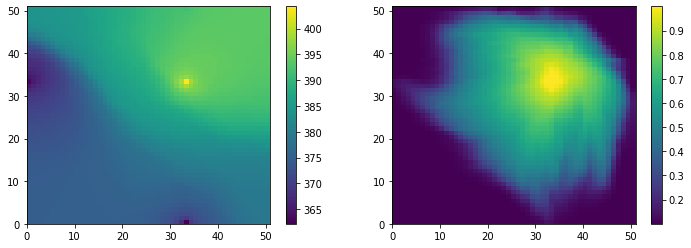

In [6]:
# run Model based on the permeability field
m = Model(k, nd, t_run=650)
m.init()
m.run()
print('Simulation completed')

# process active grid
X = np.array(m.physics.engine.X, copy=False)
nb = m.nx * m.ny

p = X[0 : 2*nb : 2]
z = X[1 : 2*nb : 2] 

# step 6 - plot solution
plt.figure(num=2, figsize=(12,4))
plt.subplot(121)
plt.pcolor(p.reshape(m.ny, m.nx))
plt.colorbar()

plt.subplot(122)
plt.pcolor(z.reshape(m.ny, m.nx))
plt.colorbar()
plt.show()

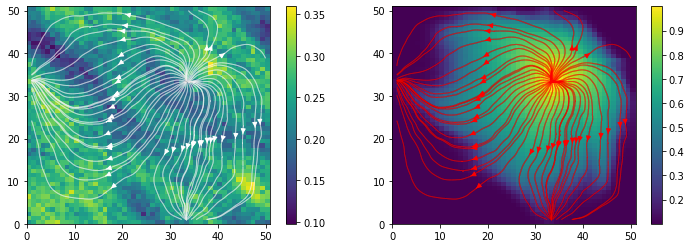

In [7]:
# step 6 - plot streamlines on porosity and composition, after water breakthrough
plt.figure(num=2, figsize=(12,4))
plt.subplot(121)
m.plot_streamline(p, phi, 'w')
plt.colorbar()

plt.subplot(122)
m.plot_streamline(p, z, 'r')
plt.colorbar()
plt.show()